In [57]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



plt.style.use(['science', 'notebook', 'grid'])
# plt.rcParams.update({
#     "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
#     "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),  # blue  with alpha = 20%
# })
plt.rcParams['axes.facecolor'] = 'white'

# Divisao de um Stroke

''Canoe paddle strokes are the means by which a paddle (or paddles) is used to move a canoe through the water.''
<p>Para este estudo é importante dividir a remada nas suas varias compomentes ou fases.</p>

<p>Da observação do movimento do sistema barco - pagaia - atleta, podemos divir as varias fases conforme a imagem a baixo:</p>

![Stroke Fases](images/Observational-model-for-kayak-analysis-including-two-levels-of-analysis-phases-and.png)

<p>Observational model for kayak analysis including two levels of analysis: phases and sub-phases. The phase defining positions are catch (1), immersion (2), extraction (3), and release (4). R, right side; L, left side. [source](https://www.researchgate.net/figure/Observational-model-for-kayak-analysis-including-two-levels-of-analysis-phases-and_fig4_233972565).</p>

In [2]:
raw_data = pd.read_csv("data/serie1.csv", names='gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord'.split(
    ','))

In [3]:
raw_data['time'] = pd.to_datetime(raw_data.time_stamp).diff().fillna(pd.Timedelta(0)).dt.total_seconds().cumsum()

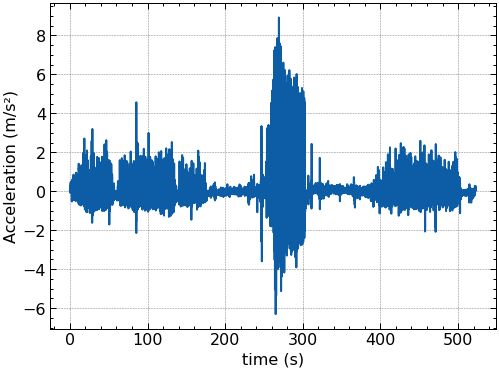

In [4]:
plt.figure()
plt.plot(raw_data['time'], raw_data.ax, label="XX Acceleration")
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.show()

In [82]:
def select_data_intervale(data, start, end):
    mask = (data.time >= start) & (data.time <= end)
    return data[mask].reset_index(drop=True).copy()

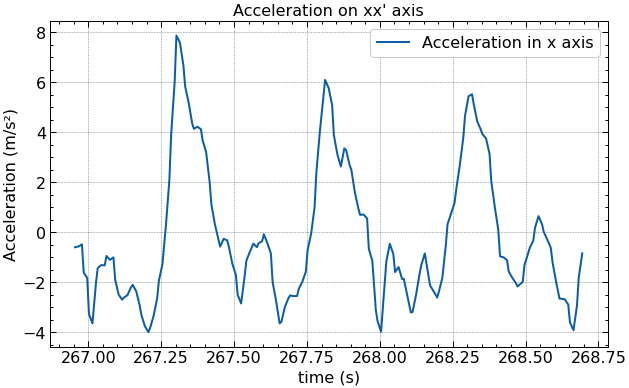

In [87]:
data = select_data_intervale(raw_data, 266.95, 268.7)
plt.figure(figsize=(10, 6))

plt.plot(data['time'], data.ax, label="Acceleration in x axis")
#plt.plot(data['time'], np.sqrt(data.ax**2+data.ay**2+data.az**2), label="Total Acceleration")
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.title("Acceleration on xx' axis")
plt.ylabel(r'Acceleration (m/s²)')
plt.savefig("images/strokes.jpeg", dpi=150)


<p>Observando o signal acima podemos ver que existem 3 strokes (3 picos), considerando que a perda de aceleração é maxima no exato momento antes de pagaia entrar na agua, podemos dizer que a faze na agua começa neste ponto e dura ate ao primeiro pico negativo, entrando na fase area</p>
<p>O entry dura até aao ponto de aceleraçao maximo, entrando depois na pull fase que dura ate a acceleração ser negativa, entrando na exit faze </p>

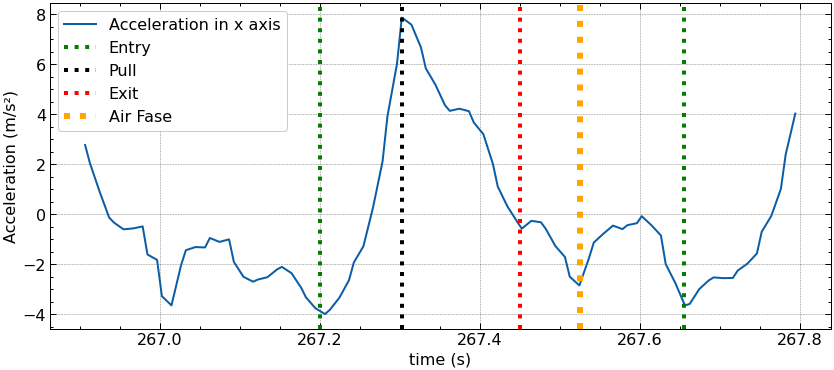

In [55]:
data = select_data_intervale(raw_data, 266.9, 267.8)
plt.figure(figsize=(14, 6))

plt.plot(data['time'], data.ax, label="Acceleration in x axis")
#plt.plot(data['time'], np.sqrt(data.ax**2+data.ay**2+data.az**2), label="Total Acceleration")
plt.axvline(x=267.2, color='green',ls=':', label='Entry', lw=4)
plt.axvline(x=267.302257, color='black',ls=':', label='Pull', lw=4)
plt.axvline(x=267.45, color='red',ls=':', label='Exit', lw=4)
plt.axvline(x=267.525, color='orange',ls=':', label='Air Fase', lw=6)
plt.axvline(x=267.655, color='green',ls=':', lw=4)
plt.xlabel('time (s)')
plt.legend(loc='upper left')

plt.ylabel(r'Acceleration (m/s²)')
plt.savefig("images/stroke.jpeg", dpi=150)

## Algoritmo para detectar strokes

In [111]:
def get_all_peaks_and_hollows(data):

    # ,threshold=0.04)
    peaks, _ = find_peaks(data.ax, distance=30, prominence=1)
    local_peaks = data.ax.iloc[peaks]
    data['max'] = local_peaks[local_peaks > 1]
    data['min'] = data.ax[(data.ax.shift(1) > data.ax) & (
        data.ax.shift(-1) > data.ax) & (data.ax < 0)]
    data_peaks = data[~(data['max'].isna())].copy()
    data_hollow = data[~(data['min'].isna())].copy()
    return data_peaks, data_hollow
def get_peaks_and_hollows(data):

    data_peaks, data_hollow = get_all_peaks_and_hollows(data)

    pk = data_peaks.copy()

    index_begin_stroke = list()
    loop_iteration = 0
    for index, row in data_peaks.iterrows():
        if loop_iteration == 0:
            time_peak = row.time
            crop = data_hollow[(data_hollow.time < time_peak)].copy()
            try:
                index_nearts_hollow = crop.time.index[-1]
                index_begin_stroke.append(index_nearts_hollow)
                last_Time = time_peak
            except IndexError:
                last_Time = time_peak
                continue
        else:
            time_peak = row.time
            crop = data_hollow[(data_hollow.time > last_Time) & (
                data_hollow.time < time_peak)].copy()

            #min_acc = crop.ax.argmin()
            #index_nearts_hollow = crop.Time.index[min_acc]
            try:
                index_nearts_hollow = crop.time.index[-1]
                index_begin_stroke.append(index_nearts_hollow)
                last_Time = time_peak
            except IndexError:
                last_Time = time_peak
                continue

        loop_iteration += 1
    hl = data.iloc[index_begin_stroke]
    hl = hl.reset_index(drop=True)
    pk = pk.reset_index(drop=True)
    return pk, hl

def get_exits(data, strokes):
    exits = data.copy()
    exits = exits.drop(index=exits.index)
    for stk in strokes:
        peak, index = get_peaks(stk)
        exitpoint = stk.iloc[[index]]
        exits = pd.concat([exits, exitpoint])
        exits = exits.sort_values(by='time', ascending=True)
        exits = exits.reset_index(drop=True)
    return exits

def get_stroke_list(data):

    stroke_list = list()

    peaks, hollows = get_peaks_and_hollows(data)
    #exits = get_exits(data, hollows)
    #data = pd.concat([data, exits])
    for index, row in hollows.iterrows():
        if index == 0:
            mask = (data.time >= row.time)
            crop = data[mask].reset_index(drop=True).copy()
            stroke_list.append(crop)
        else:
            mask = (data.time >=
                    hollows.iloc[index - 1].time) & (data.time <= row.time)
            crop = data[mask].reset_index(drop=True).copy()
            stroke_list.append(crop)
    stroke_list = stroke_list[1:]
    exits = get_exits(data, stroke_list)
    return stroke_list, exits
def get_peaks(data):
    # peaks = find_peaks_cwt(data.ax, data.Time)#, height=0)

    index_max_ax = data.ax.argmax()
    # print(index_max_ax)
    acc_ax = data.ax.iloc[index_max_ax:].copy()

    peaks = list()
    lowest_peak_value = 99999
    lowest_peak_index = 0
    for index, ax in zip(acc_ax.index, acc_ax):
        #print("Index: {} Acc: {}".format(index,ax))
        if index == index_max_ax:
            continue
        elif index == index_max_ax + len(acc_ax) - 1:
            continue
        else:
            if ax > acc_ax[index - 1] and ax > acc_ax[index + 1]:
                if abs(ax) < lowest_peak_value:
                    lowest_peak_value = ax
                    lowest_peak_index = index
    if lowest_peak_value == 99999:
        lowest_peak_index = acc_ax.abs().argmin() + index_max_ax
        #print("Lowest Index: ", lowest_peak_index)
        # rint(acc_ax)
        lowest_peak_value = acc_ax[lowest_peak_index]

        return lowest_peak_value, lowest_peak_index
    return lowest_peak_value, lowest_peak_index

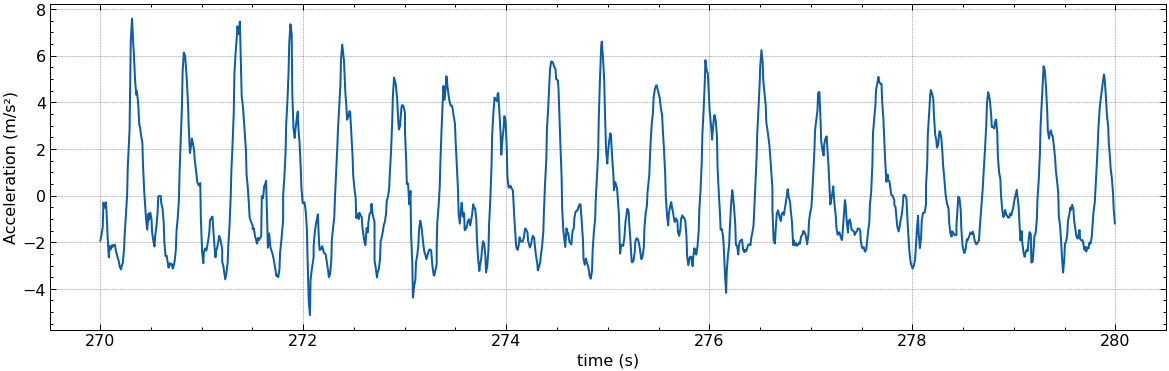

In [112]:
start_data = select_data_intervale(raw_data, start=270, end=280)
plt.figure(figsize=(20, 6))
plt.plot(start_data['time'], start_data.ax, label="XX Acceleration")
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.show()

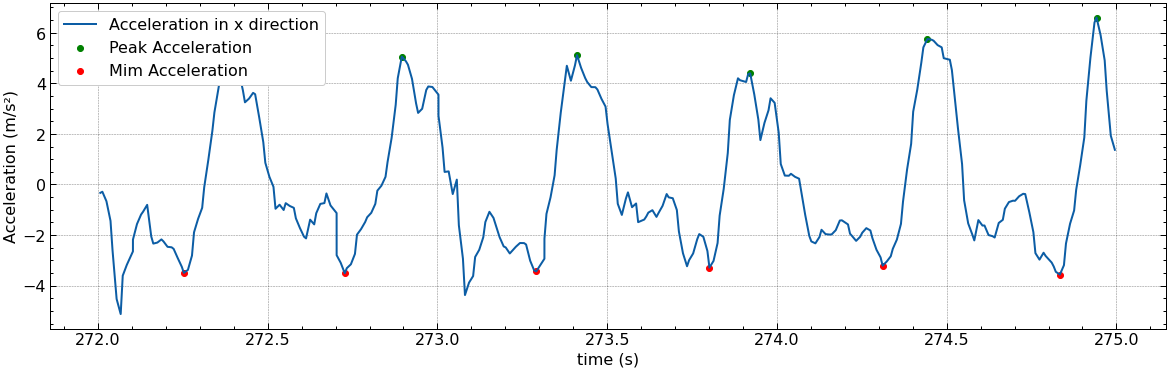

In [117]:
start_data = select_data_intervale(raw_data, start=272, end=275)
data_peaks, data_hollow = get_peaks_and_hollows(start_data)
stroke_list, exits = get_stroke_list(data)
plt.figure(figsize=(20, 6))
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.scatter(data_peaks.time, data_peaks.ax, label='Peak Acceleration', color='green')
plt.scatter(data_hollow.time, data_hollow.ax, label='Mim Acceleration', color='red')
#plt.scatter(exits.time, exits.ax, label='Exit', color='orange')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

A melhor forma para detectar para stroke é encontrar primeiro o seu maximo - peak. Para isso irei usar a funcao [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) do modulo scipy. 

This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.

Uma fez que é humanamente impossivel que um stroke veja mais curto que 0.3 segundos, podemos indicar o parametro distance como 30 - Uma vez que a sample frequency is of 100 Hz, 0.3 segundos correspondem a 30 pontos.


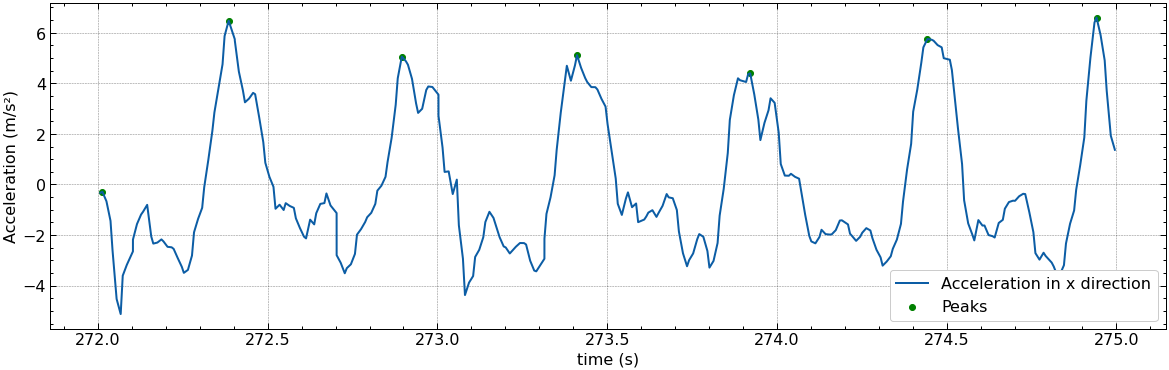

In [128]:
peaks, _ = find_peaks(start_data.ax, distance=30)
plt.figure(figsize=(20, 6))
plt.scatter(start_data['time'].iloc[peaks], start_data.ax.iloc[peaks], label=r'Peaks', color='green')
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

Uma vez encontrados os PEAKS, para detectar o entry point temos de descobrir o ponto de inflexao do sinal imediatamente antes do PEAK.

Para isso vou encontrar todos os minimos relativos com aceleração negativa e posteriormente escolher o que tiver menor distancia ao PEAK 



In [136]:
local_minimum_index = start_data.ax[(start_data.ax.shift(1) > start_data.ax) & (
    start_data.ax.shift(-1) > start_data.ax) & (start_data.ax < 0)].index
local_minimum_index
local_minimum = start_data.iloc[local_minimum_index]

In [150]:
def distance_to_peak_point(peaks, local_minimum ):
    entry_point_index = list()
    for index, row in peaks.iterrows():
        mask = (local_minimum.time < row.time)
        aux_df = local_minimum[mask]
        aux_df.sort_values(by='time')
        try:
            point_index = aux_df.tail(1).index.values[0]
        except IndexError:
            pass

        entry_point_index.append()
    return entry_point_index

In [151]:
entry_point_index = distance_to_peak_point(start_data.iloc[peaks], local_minimum )
entry_point_index

IndexError: index 0 is out of bounds for axis 0 with size 0

In [131]:
local_peaks = start_data.ax.iloc[peaks]
start_data['max'] = local_peaks[local_peaks > 1]
start_data['min'] = start_data.ax[(start_data.ax.shift(1) > start_data.ax) & (
    start_data.ax.shift(-1) > start_data.ax) & (start_data.ax < 0)]

data_peaks = start_data[~(start_data['max'].isna())].copy()
data_hollow = start_data[~(start_data['min'].isna())].copy()


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1484: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.asarray(key)


ValueError: setting an array element with a sequence.

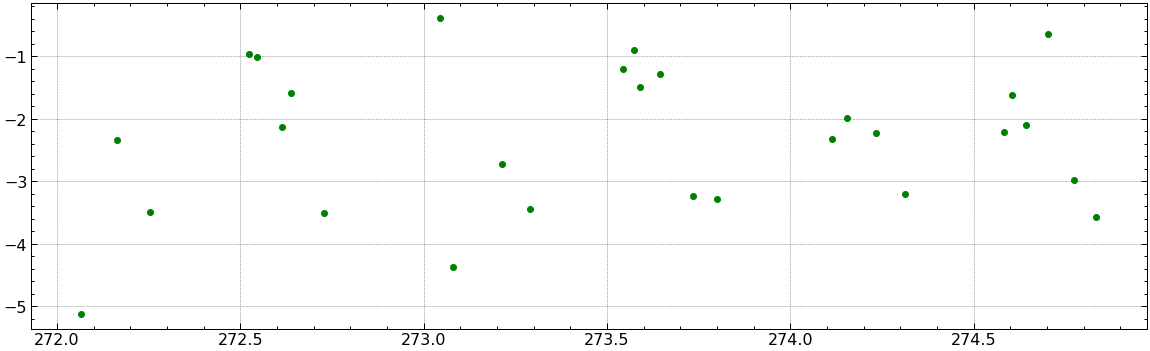

In [144]:
plt.figure(figsize=(20, 6))
plt.scatter(local_minimum['time'], local_minimum['ax'], label=r'Max', color='green')
plt.scatter(start_data['time'].iloc[entry_point_index], start_data['ax'].iloc[entry_point_index], label=r'Min', color="red")
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

In [122]:
start_data['max']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
295   NaN
296   NaN
297   NaN
298   NaN
299   NaN
Name: max, Length: 300, dtype: float64